![logo.png](https://raw.githubusercontent.com/TienTienYeh/lg-tdgl/blob/main/docs/logo.png)

# Structured light induced vorticity in superconductors I: Linearly polarized light

`LG-TDGL` provides the platform to solve the light-matter interaction between structured light and supercinducting order parameters. The solving order parameters is based on the framework of "generalized time-depdendent Ginzburg-Landau (TDGL) equation" in `pyTDGL`*. <br>
The work "Structured light induced vorticity in superconductors I: Linearly polarized light"** is based on the calculation of `LG-TDGL`. <br>
In this notebook, we provide an example of linearly polarized light induced vortex and demonstrate the results for the light imprinted superflow***.

*Link of `pyTDGL`: https://py-tdgl.readthedocs.io/en/latest/ <br>
  This code has to be executed under the environment of `pyTDGL`.
**DOI:xxxxxxxxxxxxxxxxxxxxx. <br>
***This figure is corresponds to Fig. 5 in reference "xxxxxxxxxxxxxxx".


## Common settings

In [ ]:
# Automatically install tdgl from GitHub only if running in Google Colab
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
    %pip install --quiet git+https://github.com/TienTienYeh/lg-tdgl.git
    !apt install ffmpeg


In [19]:
import light_sources.linear_gaussian as lg
import numpy as np
import tdgl
import os
from matplotlib import pyplot as plt

In [25]:

# Initialize parameters

P = lg.input_value(

    # Unit in the system
    
    length_units = "um", # SI: m
    time_units = 'ps', # SI: s
    current_units = "mA", # SI: A
    mass_units = 'kg', # SI: kg
    angular_freq_units = 'THz', # SI: 1/s # for demonstration
    field_units = "mT", # SI: kg/s^2/A
    E_field_units = "kvolt/meter", # newton per coulomb (N/C), or volt per meter (V/m), SI: kg*m^2/s^3/A
    resistivity_units = 'ohm * cm',
    f_EM = 2,

    # Properties of SC 

    xi = 0.1, # Coherent length
    london_lambda = 0.1, # London penetration depth 
    gamma = 10, # Strength of inelastic scattering
    height = 2, # Height of sample
    width = 2, # Width of sample
    thickness = 2/1000, # Thickness of sample
    temperature = 0.5, # Temperature, Unit of Tc
    resistivity = 150e-6, # Conductivity of normal state

    # Properties of linearly polarized Gaussian beam 

    E_amp = 2e6, # Input amplitude of electric field 
    w_EM = 2*np.pi * 10, # Angular frequency of light
    w_0 = 0.4, # Radius of spot of Gaussian beam
    xc_Gauss = 0, # Center position of Gaussian beam
    yc_Gauss = 0, # Center position of Gaussian beam
    light_source_type = 'linear_x', # Setting of light source by keyword. Options: "linear_x", "linear_y", "None"

    # Settings of running simulation
    
    screenSet = False, # Setting of screening effect
    solve_time = 1, # Total solving time (Unit: tau_GL)

    # Settings of figures
    
    quiver_mesh_n = 20, # Plot of E (quiver): mesh number
    quiver_scale = 5, # Plot of E (quiver): quier scale
    width_quiver = 0.1, # Plot of E (quiver): quiver width
    dpi = 100, # Dpi of figure
)

P.print_properties(['Conductivity','E0i','Bc2','A0','J0'])

# # Example of update parameter and check
# P.set_state(E_amp = 100)
# P.print_properties(['All'])

Conductivity (1/resistivity): 6666.666666666666 / centimeter / ohm
Bc2 of SC (mu0Hc2): 32.91059784754533 millitesla
Unit vector potential A0 (xi*Bc2): 3.2910597847545335 micrometer * millitesla
Unit current density (J0 = 4*xi*Bc2/mu_0/lambdaL**2): 1047.5768649389909 milliampere / micrometer ** 2


C:\Users\Tien-Tien Yeh\.conda\envs\tdgl\lib\site-packages\pint\facets\plain\quantity.py:998: RuntimeWarning: invalid value encountered in scalar divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


## Superconductor (SC) thin film

Constructing Voronoi polygons: 100%|█████████████████████████████████████████████| 5257/5257 [00:02<00:00, 2207.39it/s]


num_sites,5257
num_elements,10216
min_edge_length,1.525e-02
max_edge_length,4.969e-02
mean_edge_length,3.015e-02
min_area,1.579e-04
max_area,1.559e-03
mean_area,7.609e-04
coherence_length,1.000e-01
length_units,um


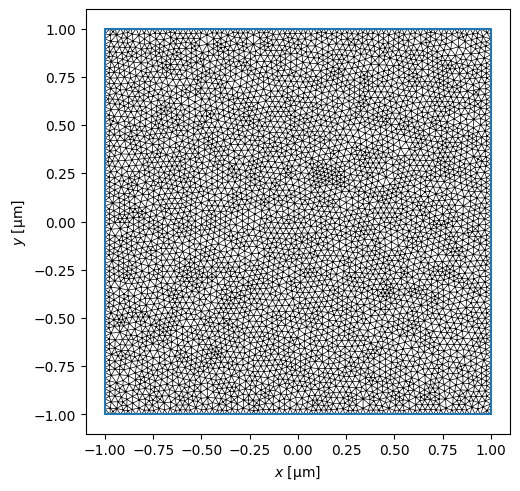

In [26]:
layer = tdgl.Layer(coherence_length=P.xi, london_lambda=P.london_lambda, thickness=P.thickness, gamma=P.gamma, u=P.u, conductivity=P.conductivity)
film = tdgl.Polygon("film", points=tdgl.geometry.box(P.width, P.height, points=301))
device = tdgl.Device("bar", layer=layer, film=film, length_units=P.length_units,)
device.make_mesh(max_edge_length=P.xi / 4, smooth=100)
fig, ax = device.plot(mesh=True, legend=False)
device.mesh_stats()

## Linear polarized Gaussian beam

C:\Users\Tien-Tien Yeh\AppData\Local\Temp\ipykernel_25880\1552755885.py:9: RuntimeWarning: invalid value encountered in divide
  lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(Phi_B/Phi_B.max()),E0i=1,title=title_set,


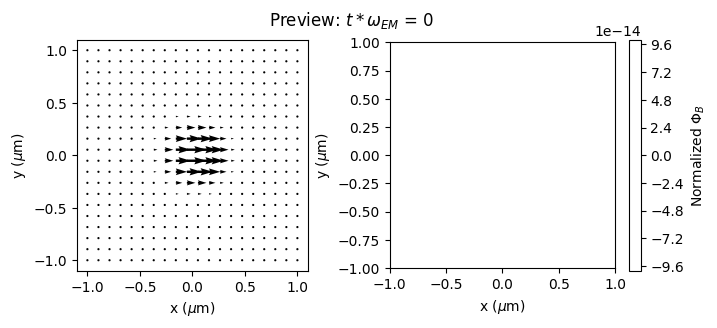

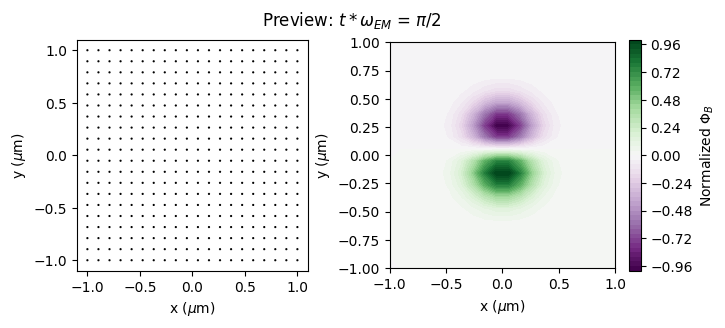

In [28]:
preview_of_EMwave = True
if preview_of_EMwave:

        title_set = 'Preview: $t*\\omega_{EM}$ = 0'
        ti = 0
        E_x, E_y = P.E_input_frame(ti,take_real=False)
        B_x, B_y, B_z = lg.E2Bv(P.Xv,P.Yv,E_x,E_y,P.constant_Bz,P.c,P.w_EM)
        Phi_B = B_z*np.pi*P.w_0**2
        lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(Phi_B/Phi_B.max()),E0i=1,title=title_set,
                   figsize=(8,3),scale=P.quiver_scale,dpi=P.dpi,width_quiver=P.width_quiver)

        title_set = 'Preview: $t*\\omega_{EM}$ = $\\pi$/2'
        ti = (2*np.pi/4) / P.w_EM
        E_x, E_y = P.E_input_frame(ti,take_real=False)
        B_x, B_y, B_z = lg.E2Bv(P.Xv,P.Yv,E_x,E_y,P.constant_Bz,P.c,P.w_EM)
        Phi_B = B_z*np.pi*P.w_0**2
        lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(Phi_B/Phi_B.max()),E0i=1,title=title_set,
                   figsize=(8,3),scale=P.quiver_scale,dpi=P.dpi,width_quiver=P.width_quiver)


## Solve TDGL model

Output file already exists. Renaming to C:\Users\Tien-Tien Yeh\Documents\Balastky\20240406_TDGL_simulation2_CalcForPaper\M1_Github\lg-tdgl\SC_solution-7.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████████▉| 1/1 [00:10<00:00, 10.59s/tau ]
C:\Users\Tien-Tien Yeh\Documents\Balastky\20240406_TDGL_simulation2_CalcForPaper\M1_Github\lg-tdgl\light_sources\linear_gaussian.py:703: UserWarning: linewidths is ignored by contourf
  contour_Bz = ax2.contourf(Xv, Yv, B_z, levels=50, linewidths=0.0, cmap="PRGn",vmin=Bzmin,vmax=Bzmax)


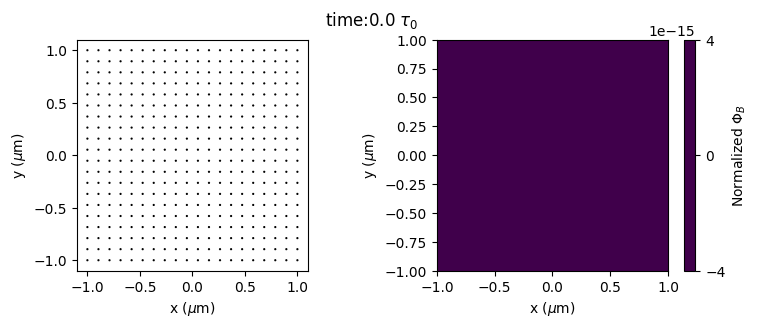

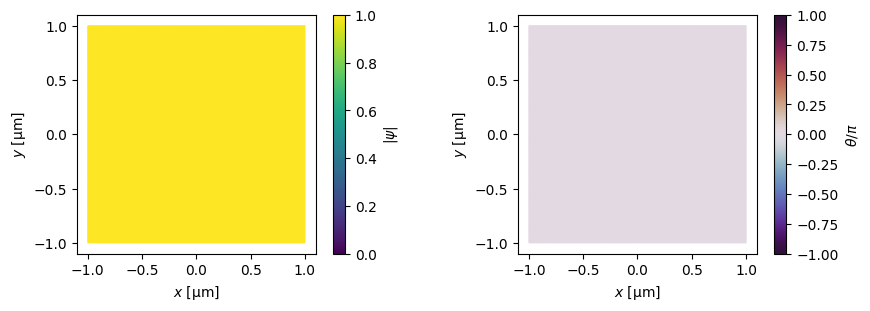

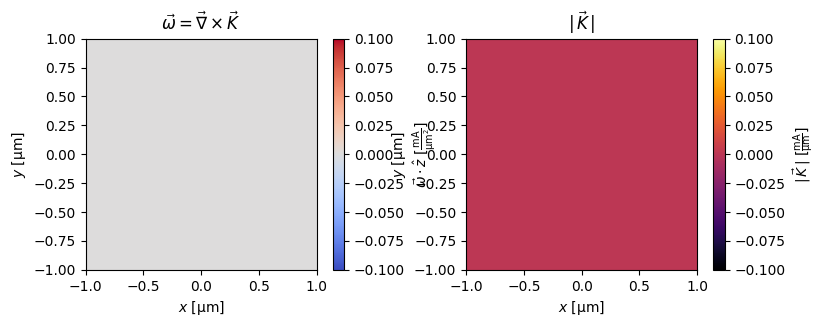

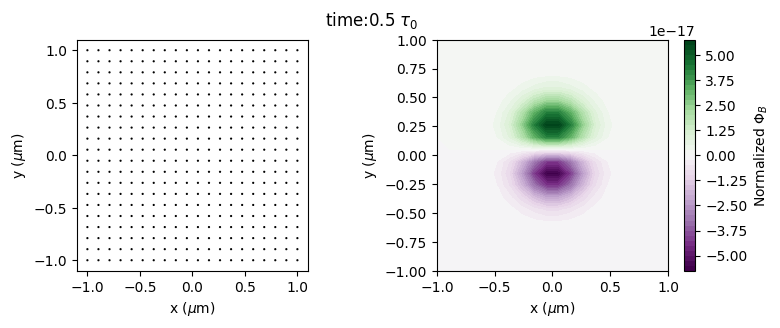

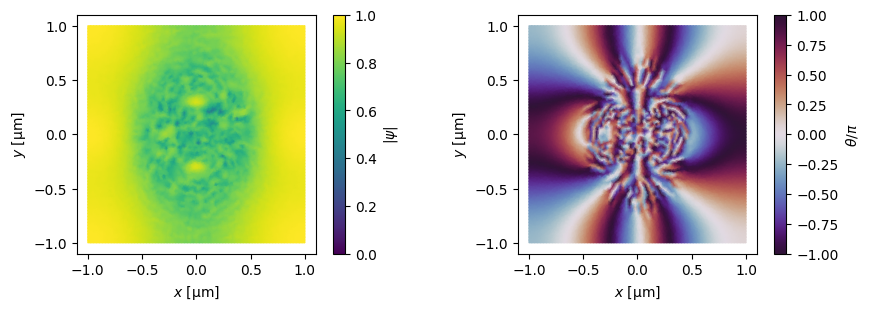

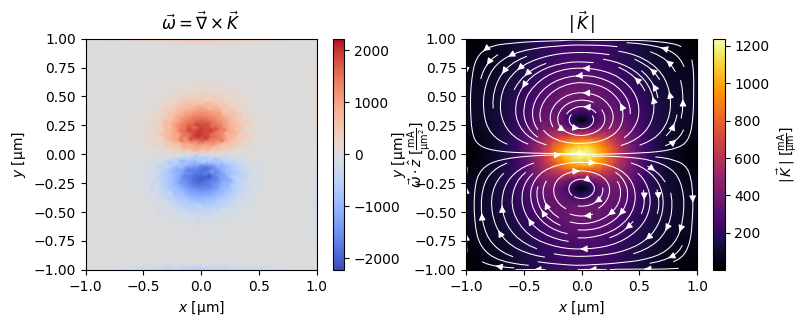

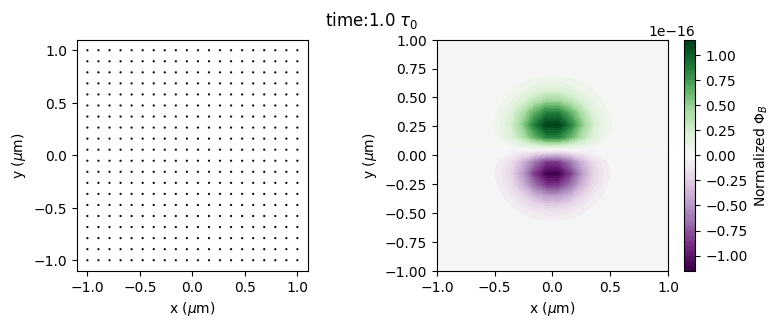

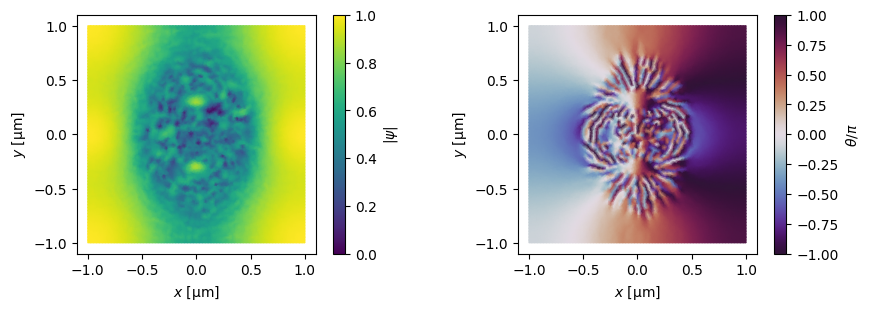

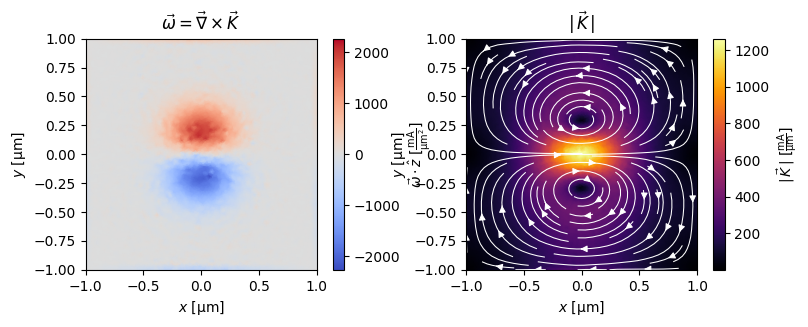

In [30]:
import tempfile
tempdir = tempfile.TemporaryDirectory()
# tempdir = os.path.join(os.getcwd(),folder_name)
Execute_GPU = False

options = tdgl.SolverOptions(
        solve_time=P.solve_time,
        field_units=P.field_units,
        current_units=P.current_units,
        include_screening=P.screenSet,
        screening_tolerance=5e-2,
        max_iterations_per_step=200000,
        screening_step_size=0.01,
        screening_step_drag=0.5,
        save_every=10,
        dt_max=1e-3,
        output_file=os.path.join(os.getcwd(), "SC_solution.h5"),
        gpu=Execute_GPU,
    )


### Solve device

applied_vector_potential = lg.A_LG(w=P.w_EM, w0=P.w_0, E0=P.E0i, phi0_t=P.phi0_t, phi0_xy=P.phi0_xy, c=P.c, tau=P.tau_GL, polarization_modulation=P.polarization_modulation,
                                angular_freq_units=P.angular_freq_units, length_units=P.length_units, E_field_units=P.E_field_units, time_units=P.time_units,)
SC_solution = tdgl.solve(device, options, applied_vector_potential=applied_vector_potential,disorder_epsilon=P.disorder_epsilon)

### Demonstrate the electrical field, order parameter, vorticity, at time in tn_set

tn_set = [0, 0.5, 1] # Unit of tau_GL
for nt in range(len(tn_set)):
    ti = tn_set[nt]
    title_set = 'time:'+str(int(ti*100)/100)+' $\\tau_0$'
    E_x, E_y = P.E_input_frame(ti,take_real=False)
    B_x, B_y, B_z = lg.E2Bv(P.Xv,P.Yv,E_x,E_y,0,P.c,P.w_EM)
    lg.plot_EM(P.X,P.Y,np.real(E_x),np.real(E_y),np.real(B_z),E0i=P.E0i,title=title_set,figsize=(9,3),scale=P.quiver_scale,dpi=P.dpi,width_quiver=P.width_quiver)

    SC_solution.solve_step = SC_solution.closest_solve_step(ti)
    fig, axes = SC_solution.plot_order_parameter(figsize=(9, 3),dpi=P.dpi)

    fig, axes = plt.subplots(1, 2, figsize=(9, 3),dpi=P.dpi)
    _ = SC_solution.plot_vorticity(ax=axes[0]) #, streamplot=False
    _ = SC_solution.plot_currents(ax=axes[1]) #, streamplot=False



import light_sources.linear_gaussian as lg
